In [1]:
import glog
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import sys

sys.path.append('../..')
import xfinai_config
from data_layer.base_dataset import FuturesDataset
from utils import path_wrapper, plotter

### 0 Loading Data

In [18]:
future_index= 'ic'
params = {
    "batch_size": 32,
    "hidden_size": 64,
    "seq_length": 8,
    "weight_decay": 0.03699014272607559,
    "num_layers": 8,
    "learning_rate": 0.1264079267383521,
#     "learning_rate": 0.0006264079267383521,
    "dropout_prob": 0.0049846528896436
#     "dropout_prob": 0.2149846528896436
}

In [3]:
# Load data
train_data = pd.read_pickle(f"{xfinai_config.featured_data_path}/{future_index}_train_data.pkl")
val_data = pd.read_pickle(f"{xfinai_config.featured_data_path}/{future_index}_val_data.pkl")
test_data = pd.read_pickle(f"{xfinai_config.featured_data_path}/{future_index}_test_data.pkl")

### 1 Define LSTM Model

In [4]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob, device, directions=1):
        super().__init__()
        self.name = 'MLP'
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.directions = directions
        self.device = device

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size, output_size)

    def init_hidden_states(self, batch_size):
        state_dim = (self.num_layers * self.directions, batch_size, self.hidden_size)
        return torch.zeros(state_dim).to(self.device), torch.zeros(state_dim).to(self.device)

    def forward(self, x, states):
        x, (h, c) = self.lstm(x, states)
        x = self.fc(x)
        return x[:, -1, :], (h, c)

In [5]:
def eval_model(model, dataloader, data_set_name, future_name, params):
    with torch.no_grad():
        y_real_list = np.array([])
        y_pred_list = np.array([])
        states = model.init_hidden_states(params['batch_size'])

        for idx, (x_batch, y_batch) in enumerate(dataloader):
            # Convert to Tensors
            x_batch = x_batch.float().to(model.device)
            y_batch = y_batch.float().to(model.device)

            states = [state.detach() for state in states]
            y_pred, states = model(x_batch, states)

            y_real_list = np.append(y_real_list, y_batch.squeeze(1).cpu().numpy())
            y_pred_list = np.append(y_pred_list, y_pred.squeeze(1).cpu().numpy())

    plt.figure(figsize=[15, 3], dpi=100)
    plt.plot(y_real_list, label=f'{data_set_name}_real')
    plt.plot(y_pred_list, label=f'{data_set_name}_pred')
    plt.legend()
    plt.title(f"Inference On {data_set_name} Set - {model.name} {future_name}")
    plt.xlabel('Time')
    plt.ylabel('Return')
    plt.subplots_adjust(bottom=0.15)

    result_dir = path_wrapper.wrap_path(f"{xfinai_config.inference_result_path}/{future_name}/{model.name}")
    plt.savefig(f"{result_dir}/{data_set_name}.png")
    

def save_model(model, future_name):
    dir_path = path_wrapper.wrap_path(f"{xfinai_config.model_save_path}/{future_name}")
    save_path = f"{dir_path}/{model.name}.pth"
    glog.info(f"Starting save model state, save_path: {save_path}")
    torch.save(model.state_dict(), save_path)

### 2 Create Training Func

In [6]:
def train(train_data_loader, model, criterion, optimizer, params):
    glog.info(f"Start Training Model")

    # Set to train mode
    model.train()
    training_states = model.init_hidden_states(params['batch_size'])
    running_train_loss = 0.0

    # Begin training
    for idx, (x_batch, y_batch) in enumerate(train_data_loader):
        optimizer.zero_grad()

        # Convert to Tensors
        x_batch = x_batch.float().to(model.device)
        y_batch = y_batch.float().to(model.device)

        # Truncated Backpropagation
        training_states = [state.detach() for state in training_states]
        # Make prediction
        y_pred, training_states = model(x_batch, training_states)

        # Calculate loss
        loss = criterion(y_pred, y_batch)
        loss.backward()
        running_train_loss += loss.item()

        optimizer.step()

    glog.info(f"End Training Model")

    train_loss_average = running_train_loss / len(train_data_loader)
    return model, train_loss_average

In [7]:
def validate(val_data_loader, model, criterion, params):
    # Set to eval mode
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        val_states = model.init_hidden_states(params['batch_size'])

        for idx, (x_batch, y_batch) in enumerate(val_data_loader):
            # Convert to Tensors
            x_batch = x_batch.float().to(model.device)
            y_batch = y_batch.float().to(model.device)

            val_states = [state.detach() for state in val_states]
            y_pred, val_states = model(x_batch, val_states)

            val_loss = criterion(y_pred, y_batch)
            running_val_loss += val_loss.item()

    val_loss_average = running_val_loss / len(val_data_loader)
    return val_loss_average

### 3 Run Training

In [8]:
# Transfer to accelerator
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Create dataset & data loader
train_dataset = FuturesDataset(data=train_data, label=xfinai_config.label, seq_length=params['seq_length'])
val_dataset = FuturesDataset(data=train_data, label=xfinai_config.label, seq_length=params['seq_length'])
test_dataset = FuturesDataset(data=test_data, label=xfinai_config.label, seq_length=params['seq_length'])
train_loader = DataLoader(dataset=train_dataset, **xfinai_config.data_loader_config,
                          batch_size=params['batch_size'])
val_loader = DataLoader(dataset=val_dataset, **xfinai_config.data_loader_config,
                        batch_size=params['batch_size'])
test_loader = DataLoader(dataset=test_dataset, **xfinai_config.data_loader_config,
                         batch_size=params['batch_size'])

In [ ]:

# create model instance
model = LSTM(
    input_size=len(train_dataset.features_list),
    hidden_size=params['hidden_size'],
    num_layers=params['num_layers'],
    output_size=xfinai_config.lstm_model_config['output_size'],
    dropout_prob=params['dropout_prob'],
    device=device
).to(device)

criterion = nn.L1Loss()

optimizer = optim.AdamW(model.parameters(),
                        lr=params['learning_rate'],
                        weight_decay=params['weight_decay'])

epochs = 50

print(model)
train_losses = []
val_losses = []
# train the model
for epoch in range(epochs):
    trained_model, train_score = train(train_data_loader=train_loader, model=model, criterion=criterion,
                                       optimizer=optimizer,
                                       params=params)
    val_score = validate(val_data_loader=val_loader, model=trained_model, criterion=criterion, params=params)

    # report intermediate result
    print(f"Epoch :{epoch} train_score {train_score} val_score {val_score}")
    train_losses.append(train_score)
    val_losses.append(val_score)

I0313 10:11:36.689117 14592 510440094.py:2] Start Training Model


LSTM(
  (lstm): LSTM(28, 64, num_layers=8, batch_first=True, dropout=0.0049846528896436)
  (dropout): Dropout(p=0.0049846528896436, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


I0313 10:11:41.019660 14592 510440094.py:29] End Training Model
I0313 10:11:43.664567 14592 510440094.py:2] Start Training Model


Epoch :0 train_score 6757.701512970993 val_score 6538.3098226300835


I0313 10:11:47.857584 14592 510440094.py:29] End Training Model
I0313 10:11:50.438400 14592 510440094.py:2] Start Training Model


Epoch :1 train_score 6378.653656735945 val_score 6234.352793716358


I0313 10:11:54.670911 14592 510440094.py:29] End Training Model
I0313 10:11:57.223743 14592 510440094.py:2] Start Training Model


Epoch :2 train_score 6091.912569620963 val_score 5888.694345282595


I0313 10:12:01.495503 14592 510440094.py:29] End Training Model
I0313 10:12:04.055998 14592 510440094.py:2] Start Training Model


Epoch :3 train_score 5656.765524540221 val_score 5470.121764260616


I0313 10:12:08.231809 14592 510440094.py:29] End Training Model
I0313 10:12:10.768264 14592 510440094.py:2] Start Training Model


Epoch :4 train_score 5371.152708208732 val_score 5299.727085825359


I0313 10:12:15.028924 14592 510440094.py:29] End Training Model
I0313 10:12:17.597178 14592 510440094.py:2] Start Training Model


Epoch :5 train_score 5255.5961166454845 val_score 5213.163436378589


I0313 10:12:21.778280 14592 510440094.py:29] End Training Model
I0313 10:12:24.369565 14592 510440094.py:2] Start Training Model


Epoch :6 train_score 5193.454566481011 val_score 5180.738094348086


I0313 10:12:28.626993 14592 510440094.py:29] End Training Model
I0313 10:12:31.208090 14592 510440094.py:2] Start Training Model


Epoch :7 train_score 5177.132782128439 val_score 5176.066450639205


I0313 10:12:35.417490 14592 510440094.py:29] End Training Model
I0313 10:12:37.955882 14592 510440094.py:2] Start Training Model


Epoch :8 train_score 5178.492465516597 val_score 5181.805547248804


I0313 10:12:42.362355 14592 510440094.py:29] End Training Model
I0313 10:12:45.063987 14592 510440094.py:2] Start Training Model


Epoch :9 train_score 5186.309275941986 val_score 5190.980872925389


I0313 10:12:49.316815 14592 510440094.py:29] End Training Model
I0313 10:12:51.872386 14592 510440094.py:2] Start Training Model


Epoch :10 train_score 5195.849331358403 val_score 5200.573847282446


I0313 10:12:56.048764 14592 510440094.py:29] End Training Model
I0313 10:12:58.601054 14592 510440094.py:2] Start Training Model


Epoch :11 train_score 5205.094471908642 val_score 5209.350018222936


I0313 10:13:02.887053 14592 510440094.py:29] End Training Model
I0313 10:13:05.454182 14592 510440094.py:2] Start Training Model


Epoch :12 train_score 5213.273037997159 val_score 5216.896084872159


I0313 10:13:09.650644 14592 510440094.py:29] End Training Model
I0313 10:13:12.249897 14592 510440094.py:2] Start Training Model


Epoch :13 train_score 5220.181243458433 val_score 5223.173145933014


I0313 10:13:16.511219 14592 510440094.py:29] End Training Model
I0313 10:13:19.051464 14592 510440094.py:2] Start Training Model


Epoch :14 train_score 5225.871049360795 val_score 5228.29645213442


I0313 10:13:23.239961 14592 510440094.py:29] End Training Model
I0313 10:13:25.790099 14592 510440094.py:2] Start Training Model


Epoch :15 train_score 5230.488916716507 val_score 5232.432458320874


I0313 10:13:30.031467 14592 510440094.py:29] End Training Model
I0313 10:13:32.584663 14592 510440094.py:2] Start Training Model


Epoch :16 train_score 5234.20465525942 val_score 5235.7502523175835


I0313 10:13:36.780897 14592 510440094.py:29] End Training Model
I0313 10:13:39.367192 14592 510440094.py:2] Start Training Model


Epoch :17 train_score 5237.179778614683 val_score 5238.404084274073


I0313 10:13:43.593700 14592 510440094.py:29] End Training Model
I0313 10:13:46.152562 14592 510440094.py:2] Start Training Model


Epoch :18 train_score 5239.557983982506 val_score 5240.524631335975


I0313 10:13:50.390611 14592 510440094.py:29] End Training Model
I0313 10:13:52.947214 14592 510440094.py:2] Start Training Model


Epoch :19 train_score 5241.457545230263 val_score 5242.217878569827


I0313 10:13:57.128613 14592 510440094.py:29] End Training Model
I0313 10:13:59.674824 14592 510440094.py:2] Start Training Model


Epoch :20 train_score 5242.975244841507 val_score 5243.571959573116


I0313 10:14:03.908513 14592 510440094.py:29] End Training Model
I0313 10:14:06.485293 14592 510440094.py:2] Start Training Model


Epoch :21 train_score 5244.189062967254 val_score 5244.654455741626


I0313 10:14:10.704517 14592 510440094.py:29] End Training Model
I0313 10:14:13.336800 14592 510440094.py:2] Start Training Model


Epoch :22 train_score 5245.1605697704845 val_score 5245.5221361954245


I0313 10:14:17.539575 14592 510440094.py:29] End Training Model
I0313 10:14:20.077097 14592 510440094.py:2] Start Training Model


Epoch :23 train_score 5245.940581545305 val_score 5246.264571340461


I0313 10:14:24.314868 14592 510440094.py:29] End Training Model
I0313 10:14:26.870935 14592 510440094.py:2] Start Training Model


Epoch :24 train_score 5246.6266283829245 val_score 5246.7888265363335


I0313 10:14:31.080867 14592 510440094.py:29] End Training Model
I0313 10:14:33.709561 14592 510440094.py:2] Start Training Model


Epoch :25 train_score 5247.075508373206 val_score 5247.231779399671


I0313 10:14:37.938356 14592 510440094.py:29] End Training Model
I0313 10:14:40.568587 14592 510440094.py:2] Start Training Model


Epoch :26 train_score 5247.4753172659985 val_score 5247.590955816388


I0313 10:14:44.896677 14592 510440094.py:29] End Training Model
I0313 10:14:47.447242 14592 510440094.py:2] Start Training Model


Epoch :27 train_score 5247.798769718152 val_score 5247.880955162231


I0313 10:14:51.668889 14592 510440094.py:29] End Training Model
I0313 10:14:54.219737 14592 510440094.py:2] Start Training Model


Epoch :28 train_score 5248.060439406399 val_score 5248.115963292464


I0313 10:14:58.474242 14592 510440094.py:29] End Training Model
I0313 10:15:01.017300 14592 510440094.py:2] Start Training Model


Epoch :29 train_score 5248.27263382177 val_score 5248.306182715311


I0313 10:15:05.226927 14592 510440094.py:29] End Training Model
I0313 10:15:07.806563 14592 510440094.py:2] Start Training Model


Epoch :30 train_score 5248.444081283642 val_score 5248.460094105114


I0313 10:15:12.001662 14592 510440094.py:29] End Training Model
I0313 10:15:14.562458 14592 510440094.py:2] Start Training Model


Epoch :31 train_score 5248.583290501645 val_score 5248.584963273774


I0313 10:15:18.757644 14592 510440094.py:29] End Training Model
I0313 10:15:21.307682 14592 510440094.py:2] Start Training Model


Epoch :32 train_score 5248.695805453798 val_score 5248.686352889504


I0313 10:15:25.517585 14592 510440094.py:29] End Training Model
I0313 10:15:28.062595 14592 510440094.py:2] Start Training Model


Epoch :33 train_score 5248.787303285736 val_score 5248.768578050239


I0313 10:15:32.264539 14592 510440094.py:29] End Training Model
I0313 10:15:34.815004 14592 510440094.py:2] Start Training Model


Epoch :34 train_score 5248.861412230861 val_score 5248.834956264952


I0313 10:15:38.990256 14592 510440094.py:29] End Training Model
I0313 10:15:41.579251 14592 510440094.py:2] Start Training Model


Epoch :35 train_score 5248.921262896232 val_score 5248.888534034839


I0313 10:15:45.844511 14592 510440094.py:29] End Training Model
I0313 10:15:48.375717 14592 510440094.py:2] Start Training Model


Epoch :36 train_score 5248.970079339862 val_score 5248.932362533642


I0313 10:15:52.583772 14592 510440094.py:29] End Training Model
I0313 10:15:55.201670 14592 510440094.py:2] Start Training Model


Epoch :37 train_score 5249.009795996561 val_score 5248.968198639354


I0313 10:15:59.534494 14592 510440094.py:29] End Training Model
I0313 10:16:02.120122 14592 510440094.py:2] Start Training Model


Epoch :38 train_score 5249.042153390401 val_score 5248.997021250748


I0313 10:16:06.572133 14592 510440094.py:29] End Training Model
I0313 10:16:09.190363 14592 510440094.py:2] Start Training Model


Epoch :39 train_score 5249.068333675987 val_score 5249.020470432117


I0313 10:16:13.664391 14592 510440094.py:29] End Training Model
I0313 10:16:16.369060 14592 510440094.py:2] Start Training Model


Epoch :40 train_score 5249.08961713143 val_score 5249.03978908119


I0313 10:16:20.934871 14592 510440094.py:29] End Training Model
I0313 10:16:23.750722 14592 510440094.py:2] Start Training Model


Epoch :41 train_score 5249.10640325957 val_score 5249.054608066686


I0313 10:16:28.336776 14592 510440094.py:29] End Training Model
I0313 10:16:31.059542 14592 510440094.py:2] Start Training Model


Epoch :42 train_score 5249.120544725628 val_score 5249.067312724283


I0313 10:16:35.579880 14592 510440094.py:29] End Training Model
I0313 10:16:38.549168 14592 510440094.py:2] Start Training Model


Epoch :43 train_score 5249.131557920903 val_score 5249.07759466582


I0313 10:16:43.291266 14592 510440094.py:29] End Training Model
I0313 10:16:45.994149 14592 510440094.py:2] Start Training Model


Epoch :44 train_score 5249.14094039698 val_score 5249.085832367673


I0313 10:16:50.282296 14592 510440094.py:29] End Training Model
I0313 10:16:53.191934 14592 510440094.py:2] Start Training Model


Epoch :45 train_score 5249.148811303828 val_score 5249.092679986543


I0313 10:16:57.955164 14592 510440094.py:29] End Training Model


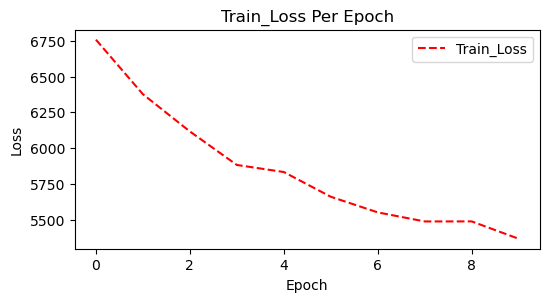

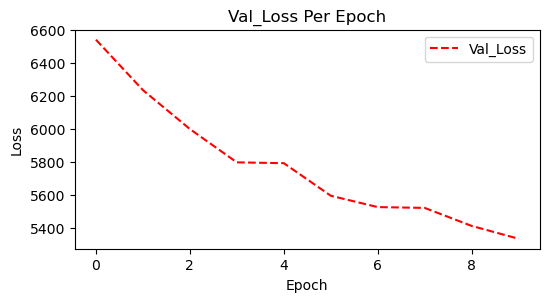

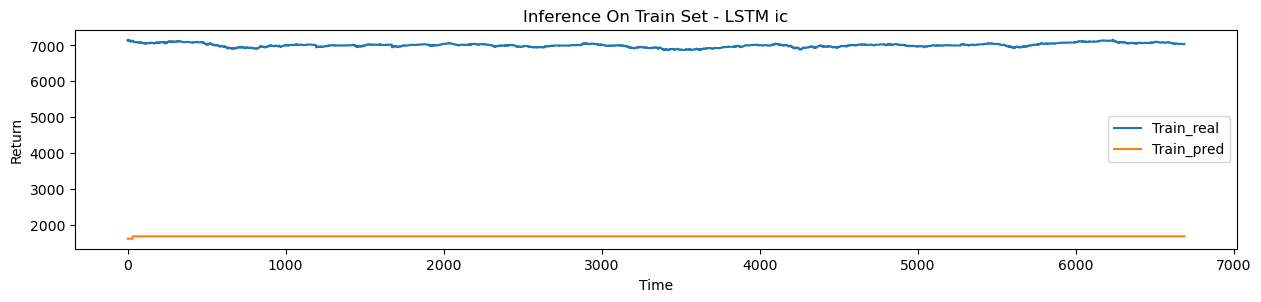

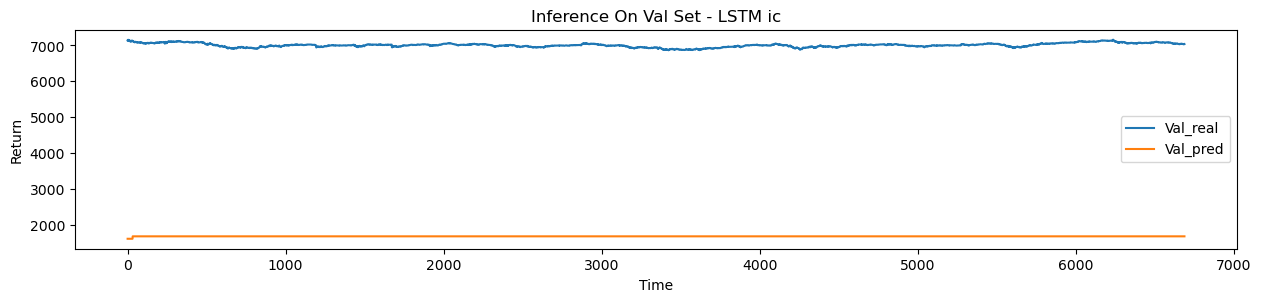

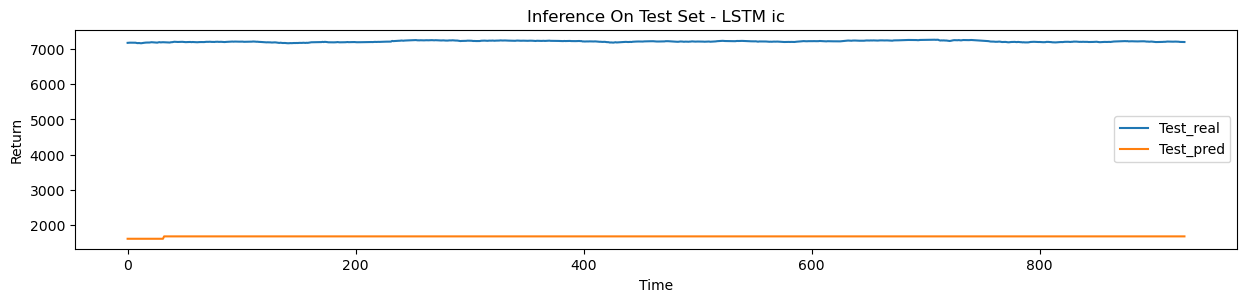

In [20]:
# # save the model
# save_model(trained_model, future_index)

# plot losses
plotter.plot_loss(train_losses, epochs, 'Train_Loss', trained_model.name, future_index)
plotter.plot_loss(val_losses, epochs, 'Val_Loss', trained_model.name, future_index)

# eval model on 3 datasets
for dataloader, data_set_name in zip([train_loader, val_loader, test_loader],
                                     ['Train', 'Val', 'Test']):
    eval_model(model=trained_model, dataloader=dataloader, data_set_name=data_set_name,
               future_name=future_index, params=params)